**OBJECTIVE:**
Amazon Text Classification using KNN

# Amazon Fine Food Reviews Analysis
Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import re
import sqlite3
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords #to remove common words
from nltk.stem import SnowballStemmer #root form of words
from nltk.corpus import words
 
from sklearn.feature_extraction.text import CountVectorizer #bagofwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score #to avoid overfitting
from sklearn.preprocessing import StandardScaler #Pre-Processing
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')

**Loading the data**

(525814, 10)


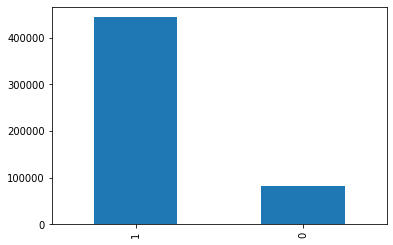

In [ ]:
#1. connect to the database
conn=sqlite3.connect('/content/drive/My Drive/database.sqlite')
#2.read from sql file using pandas
food_data=pd.read_sql('SELECT * FROM Reviews where Score!=3',con=conn)
#3.Product with score less than 3 is considered as negative and between 4 and 5 as Positive
food_data['Score']=food_data['Score'].map(lambda x:0 if x<3 else 1 )
ax=food_data['Score'].value_counts().plot(kind='bar')
print(food_data.shape)
#observation:the datset is imbalanced

In [ ]:
food_data['Score'].value_counts(normalize=True)

1    0.843981
0    0.156019
Name: Score, dtype: float64

In [ ]:
#For same Prodcut reviews are repeating which should be removed inorder to 
pd.read_sql_query('SELECT * FROM Reviews where UserId="A2725IB4YY9JEB" order by ProductId',conn)

** Data Cleaning**
1. Sort reviews by ProductId
2. Remove duplicates reviews 
3. HelpfulnessDeno>HelpfulnessNum

In [ ]:
#1.Sort 
sort_food_data=food_data.sort_values(by=['ProductId'],kind='quicksort')
#2.Delete Duplicates
food_reviews=sort_food_data.drop_duplicates(subset=['Score','Summary','Time'],keep='first')
#3.HelfullnessDenominator<HelfulnessNumerator
food_reviews=food_reviews[food_reviews['HelpfulnessNumerator']<=food_reviews['HelpfulnessDenominator']]
food_reviews.shape

(358005, 10)

**Text Preprocessing**

1. Removal html tags
2. Removal stopwords
3. Removal lowercase words
3. Stemming-root form of words
4. Removal of punctuations
5. Removal of 
6. Removal of words whose length is less than 2 
7. Lemmatization 

In [ ]:
stop_words=set(stopwords.words('english'))
sno=SnowballStemmer('english')
def clean_html_punc(text):
    clean_html=re.sub(re.compile(r'<.*?>')," ",text)
    clean_repeat=re.sub(re.compile(r'(.)\1{3,}\w*'),' ',clean_html)
    clean_punc=re.sub(re.compile(r'[^\w\s]')," ",clean_repeat)
    return clean_punc
final_reviews=[]
for review in food_reviews['Text'].values:
    filtered_sentence=[]
    list_words=clean_html_punc(review)
    for word in list_words.split():
        if word.lower() not in stop_words and len(word)>2 and word.isalpha(): 
            new_word=(sno.stem(word.lower())).encode('utf8')
            filtered_sentence.append(new_word)
    s=b' '.join(filtered_sentence)
    final_reviews.append(s) 
food_reviews['clean_text']=final_reviews
food_reviews['clean_text']=food_reviews['clean_text'].str.decode('utf-8')
food_reviews

In [ ]:
#time based split
food_reviews=food_reviews.sort_values(by="Time",inplace=False,ascending=True,kind='quicksort')

In [ ]:
food_reviews.Score.value_counts()

1    301162
0     56843
Name: Score, dtype: int64

# Bag Of Words

In [ ]:
#split data to train and test
x,y=food_reviews['clean_text'].values,food_reviews.Score.values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

bow=CountVectorizer(min_df=5) #Binary BOW
x_train=bow.fit_transform(x_train)#learn vocabulary
x_test=bow.transform(x_test)#learn vocab from x_train to return same size sparse matrix

**Logistic Regression**


In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=200)
LR.fit(x_train, y_train)
predict=LR.predict(x_test)
accuracy=accuracy_score(y_test,predict,normalize=True)
accuracy

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9202063276289082

In [ ]:
feature_names = np.array(bow.get_feature_names())
sorted_coef_index = LR.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['weakest' 'compass' 'emptor' 'worst' 'holl' 'ick' 'unimpress' 'argan'
 'unaccept' 'downhil']

Largest Coefs: 
['smoothest' 'skeptic' 'downsid' 'awsom' 'finest' 'terrif' 'swore'
 'conjunct' 'repack' 'fascin']



In [ ]:
print(LR.predict(bow.transform(['worst pizza ever','The candy is not bad, I will buy them again'])))

[0 1]


# TF-IDF

In [ ]:
#split data to train and test
x,y=food_reviews['clean_text'].values,food_reviews.Score.values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

#tf
tf_idf=TfidfVectorizer(smooth_idf=True,ngram_range=(1,2),min_df=5)
x_train=tf_idf.fit_transform(x_train)
x_test=tf_idf.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=200)
model.fit(x_train, y_train)
predict=model.predict(x_test)
accuracy=accuracy_score(y_test,predict,normalize=True)
accuracy

0.9286698571721197

In [ ]:
feature_names = np.array(tf_idf.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['disappoint' 'worst' 'terribl' 'return' 'aw' 'horribl' 'unfortun' 'stale'
 'bland' 'threw']

Largest Coefs: 
['great' 'best' 'delici' 'love' 'perfect' 'excel' 'high recommend' 'nice'
 'good' 'amaz']

